<a href="https://colab.research.google.com/github/alexdrane/GaussianHeartRate/blob/main/Gaussian_Heart_Rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tinygp
!pip install jaxopt
!pip install git+https://github.com/handley-lab/blackjax@nested_sampling
!pip install mpi4py corner jaxopt
!pip install corner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.4/172.4 kB 8.6 MB/s eta 0:00:00
  Cloning https://github.com/handley-lab/blackjax (to revision nested_sampling) to /tmp/pip-req-build-msb3r51x
  Running command git clone --filter=blob:none --quiet https://github.com/handley-lab/blackjax /tmp/pip-req-build-msb3r51x
  Resolved https://github.com/handley-lab/blackjax to commit 95e93ed93e726b95143b2f4a9582888621625f52
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 7.7 MB/s eta 0:00:00
  Created wheel for blackjax: filename=blackjax-0.1.dev717+g95e93ed93-py3-none-any.whl size=4672732 sha256=b50acd4b1c88828104c48a87fc

In [ ]:
!pip install intervalsicu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.1/280.1 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: pluggy
    Found existing installation: pluggy 1.6.0
    Uninstalling pluggy-1.6.0:
      Successfully uninstalled pluggy-1.6.0
  Attempting uninstall: pytest
    Found existing installation: pytest 8.4.2
    Uninstalling pytest-8.4.2:
      Successfully uninstalled pytest-8.4.2


In [ ]:
import os
import datetime
from datetime import date
# from intervalsicu import Intervals
import requests
import pprint

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## **Intervals.icu Import**

In [ ]:
ATHLETE_ID = os.getenv("INTERVALS_ATHLETE_ID", "i347906")
API_KEY = os.getenv("INTERVALS_API_KEY", "2md7ofnfisjyaqe7uoeujowz")


In [ ]:
svc = Intervals("i347906","2md7ofnfisjyaqe7ioeujowz", strict=False)

start = date.fromisoformat("2024-07-12")
wellness = svc.wellness(start)
wellness = svc.wellness_put(wellness)
pprint.pprint(wellness)

{'abdomen': None,
 'atl': 13.479111,
 'atlLoad': 56.0,
 'avgSleepingHR': None,
 'baevskySI': None,
 'bloodGlucose': None,
 'bodyFat': None,
 'comments': None,
 'ctl': 16.135424,
 'ctlLoad': 56.0,
 'diastolic': None,
 'fatigue': None,
 'hrv': None,
 'hrvSDNN': None,
 'hydration': None,
 'hydrationVolume': None,
 'id': '2024-07-12',
 'injury': None,
 'kcalConsumed': None,
 'lactate': None,
 'locked': None,
 'menstrualPhase': None,
 'menstrualPhasePredicted': None,
 'mood': None,
 'motivation': None,
 'rampRate': 0.3991413,
 'readiness': None,
 'respiration': None,
 'restingHR': 56,
 'sleepQuality': None,
 'sleepScore': None,
 'sleepSecs': 16560,
 'soreness': None,
 'spO2': None,
 'sportInfo': [{'eftp': None, 'pMax': None, 'type': 'Ride', 'wPrime': None}],
 'steps': 10387,
 'stress': None,
 'systolic': None,
 'tempRestingHR': False,
 'tempWeight': False,
 'updated': '2025-11-19T19:53:18.373+00:00',
 'vo2max': 52.0,
 'weight': 85.0}


In [ ]:
START_DATE = date(2024, 3, 5)
END_DATE = date.today()

dates = []
resting_hr = []




current_date = START_DATE
while current_date <= END_DATE:
    try:
        wellness = svc.wellness(current_date)
        if wellness.get('restingHR'):
            dates.append(current_date)
            resting_hr.append(wellness['restingHR'])
            print(f"Date: {current_date}, Resting HR: {wellness['restingHR']}")
    except Exception as e:
        print(f"Could not fetch data for {current_date}: {e}")
    current_date += datetime.timedelta(days=1)




Could not fetch data for 2024-03-05: name 'svc' is not defined
Could not fetch data for 2024-03-06: name 'svc' is not defined
Could not fetch data for 2024-03-07: name 'svc' is not defined
Could not fetch data for 2024-03-08: name 'svc' is not defined
Could not fetch data for 2024-03-09: name 'svc' is not defined
Could not fetch data for 2024-03-10: name 'svc' is not defined
Could not fetch data for 2024-03-11: name 'svc' is not defined
Could not fetch data for 2024-03-12: name 'svc' is not defined
Could not fetch data for 2024-03-13: name 'svc' is not defined
Could not fetch data for 2024-03-14: name 'svc' is not defined
Could not fetch data for 2024-03-15: name 'svc' is not defined
Could not fetch data for 2024-03-16: name 'svc' is not defined
Could not fetch data for 2024-03-17: name 'svc' is not defined
Could not fetch data for 2024-03-18: name 'svc' is not defined
Could not fetch data for 2024-03-19: name 'svc' is not defined
Could not fetch data for 2024-03-20: name 'svc' is not 

In [ ]:
path = '/content/drive/My Drive/intervals/biometrics.csv'
import pandas as pd
df = pd.DataFrame({'Date': dates, 'restingHR': resting_hr})
df.to_csv(path, index=False)
print(f"Saved to {path}")


Saved to /content/drive/My Drive/intervals/biometrics.csv


## **Start Here for CSV import**

In [ ]:
path = '/content/drive/My Drive/intervals/biometrics.csv'
import pandas as pd
df = pd.read_csv(path)
dates = pd.to_datetime(df['Date']).tolist()
resting_hr = df['restingHR'].tolist()
# dates = dates[40:]
# resting_hr = resting_hr[40:]
dates = dates[40:80]
resting_hr = resting_hr[40:80]
print(dates)
print(resting_hr)

[Timestamp('2024-05-07 00:00:00'), Timestamp('2024-05-08 00:00:00'), Timestamp('2024-05-09 00:00:00'), Timestamp('2024-05-10 00:00:00'), Timestamp('2024-05-11 00:00:00'), Timestamp('2024-05-12 00:00:00'), Timestamp('2024-05-13 00:00:00'), Timestamp('2024-05-14 00:00:00'), Timestamp('2024-05-15 00:00:00'), Timestamp('2024-05-16 00:00:00'), Timestamp('2024-05-17 00:00:00'), Timestamp('2024-05-18 00:00:00'), Timestamp('2024-05-19 00:00:00'), Timestamp('2024-05-20 00:00:00'), Timestamp('2024-05-21 00:00:00'), Timestamp('2024-05-22 00:00:00'), Timestamp('2024-05-23 00:00:00'), Timestamp('2024-05-24 00:00:00'), Timestamp('2024-05-25 00:00:00'), Timestamp('2024-05-26 00:00:00'), Timestamp('2024-05-27 00:00:00'), Timestamp('2024-05-28 00:00:00'), Timestamp('2024-05-29 00:00:00'), Timestamp('2024-05-30 00:00:00'), Timestamp('2024-05-31 00:00:00'), Timestamp('2024-06-01 00:00:00'), Timestamp('2024-06-02 00:00:00'), Timestamp('2024-06-03 00:00:00'), Timestamp('2024-06-04 00:00:00'), Timestamp('20

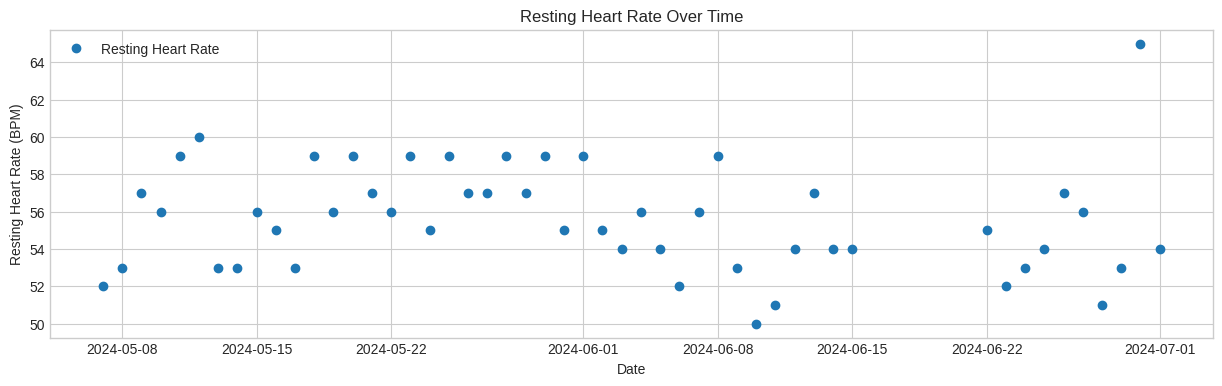

In [ ]:
import matplotlib.pyplot as plt
if dates:
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(15, 4))

    ax.plot(dates, resting_hr, 'o', label='Resting Heart Rate')

    # Formatting the plot
    ax.set_title('Resting Heart Rate Over Time')
    ax.set_xlabel('Date')
    ax.set_ylabel('Resting Heart Rate (BPM)')
    ax.legend()
    ax.grid(True)

    # Improve date formatting on the x-axis

    plt.show()
else:
    print("No resting heart rate data found to plot.")

In [ ]:
from jax.scipy.linalg import solve_triangular, cho_solve

def compute_logZ(mu_L, Sigma_L, logLmax=0, mu_pi=None, Sigma_pi=None):
    """
    Compute log evidence, posterior covariance, and posterior mean.

    Args:
        mu_L: Likelihood mean
        Sigma_L: Likelihood covariance
        logLmax: Maximum log likelihood value
        mu_pi: Prior mean
        Sigma_pi: Prior covariance

    Returns:
        Tuple of (log evidence, posterior covariance, posterior mean)
    """
    # Use Cholesky decomposition for more stable calculations
    L_pi = jnp.linalg.cholesky(Sigma_pi)
    L_L = jnp.linalg.cholesky(Sigma_L)

    # Compute precision matrices (inverse covariances)
    prec_pi = cho_solve((L_pi, True), jnp.eye(L_pi.shape[0]))
    prec_L = cho_solve((L_L, True), jnp.eye(L_L.shape[0]))

    # Compute posterior precision and its Cholesky factor
    prec_P = prec_pi + prec_L
    L_P = jnp.linalg.cholesky(prec_P)

    # Compute Sigma_P using Cholesky factor
    Sigma_P = cho_solve((L_P, True), jnp.eye(L_P.shape[0]))

    # Compute mu_P more stably
    b = cho_solve((L_pi, True), mu_pi) + cho_solve((L_L, True), mu_L)
    mu_P = cho_solve((L_P, True), b)

    # Compute log determinants using Cholesky factors
    logdet_Sigma_P = -2 * jnp.sum(jnp.log(jnp.diag(L_P)))
    logdet_Sigma_pi = 2 * jnp.sum(jnp.log(jnp.diag(L_pi)))

    # Compute quadratic forms using Cholesky factors
    diff_pi = mu_P - mu_pi
    diff_L = mu_P - mu_L
    quad_pi = jnp.sum(jnp.square(solve_triangular(L_pi, diff_pi, lower=True)))
    quad_L = jnp.sum(jnp.square(solve_triangular(L_L, diff_L, lower=True)))

    return (
        (
            logLmax
            + logdet_Sigma_P / 2
            - logdet_Sigma_pi / 2
            - quad_pi / 2
            - quad_L / 2
        ),
        Sigma_P,
        mu_P,
    )

log_analytic_evidence, post_cov, post_mean = compute_logZ(
    like_mean,
    like_cov,
    mu_pi=prior_mean,
    Sigma_pi=prior_cov,
    logLmax=loglikelihood_function(like_mean),
)

NameError: name 'like_mean' is not defined

In [ ]:
import time
import jax
import jax.numpy as jnp
from jax.scipy.stats import norm
from jax import jit, vmap, random, value_and_grad, lax
from jax.scipy.special import logsumexp, gammaln
from jax.flatten_util import ravel_pytree
import tinygp
import blackjax
from functools import partial
import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import optax
import numpy as np
import jaxopt
from jax.scipy.linalg import solve_triangular, cho_solve
from blackjax.ns.utils import log_weights, finalise, sample, ess


# Enable 64-bit precision
jax.config.update("jax_enable_x64", True)
jax.clear_caches()

# ==========================================
# 1. SETUP: DATA & MODEL
# ==========================================

rng_key = jax.random.PRNGKey(42)
# X = jnp.linspace(0, 600, 100) # Days
# true_trend = 55 + 0.01 * X
# true_periodic = 5.0 * jnp.sin(2 * jnp.pi * X / 7.0)
# y = true_trend + true_periodic + 2.0 * jax.random.normal(rng_key, X.shape)

start_date = dates[0]
X = jnp.array([(date - start_date).days for date in dates])
y = jnp.array(resting_hr)
print(f"Data points: {len(X)}")


y0, y1, x1 = y[0], y[-1], X[-1]

def build_gp(params, X):
    kernel_trend = jnp.exp(2 * params["log_amp_trend"]) * tinygp.kernels.Matern32(jnp.exp(params["log_scale_trend"]))
    kernel_periodic = jnp.exp(2 * params["log_amp_periodic"]) * tinygp.kernels.ExpSineSquared(
        scale=jnp.exp(params["log_period"]), gamma=jnp.exp(params["log_gamma_periodic"]))
    kernel = kernel_trend + kernel_periodic

    return tinygp.GaussianProcess(kernel, X, diag=jnp.exp(2 * params["log_jitter"]), mean = params['mean'])

prior_params = {
    "log_jitter": (-1.0, 1.0), "log_amp_trend": (0.0, 2.0), "log_scale_trend": (2.0, 2.0),
    "log_amp_periodic": (0.0, 2.0), "log_period": (2.0, 2.0), "log_gamma_periodic": (0.0, 2.0), "mean": (0.0, 100.0)
}

init_dummy = {k: v[0] for k, v in prior_params.items()}
flat_init, unravel_fn = ravel_pytree(init_dummy)
D = len(flat_init)

# ==========================================
# 2. LOG PROBS
# ==========================================
t0 = time.time()
@jit
def log_likelihood_flat(theta_flat):
    params = unravel_fn(theta_flat)
    gp = build_gp(params, X)
    return gp.log_probability(y)

@jit
def log_prior_flat(theta_flat):
    params = unravel_fn(theta_flat)
    logp = 0.0
    for k, (loc, scale) in prior_params.items():
        logp += norm.logpdf(params[k], loc=loc, scale=scale)
    return logp

@jit
def log_posterior_total(theta):
    return log_likelihood_flat(theta) + log_prior_flat(theta)

# ==========================================
# 3. RUN 1: BASELINE
# ==========================================
print("--- STARTING RUN 1: BASELINE ---")

n_live = 500
num_delete = n_live // 2
ns_algo = blackjax.nss(
    logprior_fn=log_prior_flat, loglikelihood_fn=log_likelihood_flat,
    num_delete=num_delete, num_inner_steps=D * 2
)

# Init Particles
rng_key, init_key = jax.random.split(rng_key)
init_particles_list = []
for _ in range(n_live):
    rng_key, subk = random.split(rng_key)
    p_samp = {k: loc + scale * random.normal(random.fold_in(subk, i))
              for i, (k, (loc, scale)) in enumerate(prior_params.items())}
    init_particles_list.append(ravel_pytree(p_samp)[0])
initial_particles = jnp.stack(init_particles_list)

state = ns_algo.init(initial_particles, log_likelihood_flat)
step_fn = jit(ns_algo.step)

@jax.jit
def one_step(carry, xs):
    state, k = carry
    k, subk = jax.random.split(k, 2)
    state, dead_point = ns_algo.step(subk, state)
    return (state, k), dead_point

dead_baseline = []

with tqdm.tqdm(desc="Dead points", unit=" dead points") as pbar:
    while not state.logZ_live - state.logZ < -5:
        (state, rng_key), dead_info = one_step((state, rng_key), None)
        dead_baseline.append(dead_info)
        pbar.update(num_delete)

t_base = time.time() - t0
logZ_base = state.logZ
print(f"Baseline LogZ: {logZ_base:.2f} | Time: {t_base:.2f}s")

rng_key, weight_key, sample_key = jax.random.split(rng_key,3)
final_state = finalise(state,dead_baseline)
log_w = log_weights(weight_key, final_state, shape=100)
samples = sample(sample_key, final_state, shape = n_live)
ns_ess = ess(sample_key, final_state)

logzs = jax.scipy.special.logsumexp(log_w, axis=0)
print(f"ESS: {int(ns_ess)}")
print(f"logZ estimate: {logzs.mean():.2f} +- {logzs.std():.2f}")
# print(f"analytic logZ: {log_analytic_evidence:.2f}")

# Posterior for fitting
posterior_samples = samples


# ==========================================
# 4. FITTING PHASE
# ==========================================
print("\n--- FITTING REPARTITIONED PRIOR ---")
n_live = 500
n_sample = 200
t_opt_start = time.time()
rng_key, init_key = jax.random.split(rng_key)
init_particles_list = []
for _ in range(n_sample):
    rng_key, subk = random.split(rng_key)
    p_samp = {k: loc + scale * random.normal(random.fold_in(subk, i))
              for i, (k, (loc, scale)) in enumerate(prior_params.items())}
    init_particles_list.append(ravel_pytree(p_samp)[0])
initial_particles = jnp.stack(init_particles_list)

initial_particles = posterior_samples
t_particles = time.time()
print(f"Particle init time {t_particles-t_opt_start:.2f}s")
# --- Definitions ---
def find_modes_fast(rng, samples, n_candidates=n_sample):
    # 1. Select candidates
    idx = random.choice(rng, len(samples), shape=(n_candidates,), replace=False)
    starts = samples[idx]

    # 2. Aggressive Optimizer Schedule
    n_steps = 40
    schedule = optax.cosine_decay_schedule(init_value=0.5, decay_steps=n_steps, alpha=0.02)

    optimizer = optax.chain(
        optax.clip_by_global_norm(10.0),
        optax.adam(learning_rate=schedule)
    )

    def optimize_single(start_pt):
        state = optimizer.init(start_pt)
        def step(c, _):
            p, s = c
            val, grads = value_and_grad(lambda x: -log_posterior_total(x))(p)
            updates, s = optimizer.update(grads, s)
            return (optax.apply_updates(p, updates), s), None
        (final_pt, _), _ = lax.scan(step, (start_pt, state), None, length=n_steps)
        return final_pt

    # 3. Parallel Execution
    candidates = vmap(optimize_single)(starts)

    # 4. Fast JAX Deduplication
    rounded_cands = jnp.round(candidates, decimals=1)
    _, unique_indices = jnp.unique(rounded_cands, axis=0, return_index=True)
    unique_modes = candidates[unique_indices]
    # Filter out NaNs
    mask = jnp.all(jnp.isfinite(unique_modes), axis=1)
    unique_modes = unique_modes[mask]

    return unique_modes

@jit
def fit_tails_fast(samples, modes, raw_hessians):
    k = len(modes)
    D = samples.shape[1]
    safety_fact = 100
    # 1. Pre-calculate Base Precision (-H)
    # The paper says P = - (nu / (nu + d)) * H.
    # We compute Base_P = -H (cleaned) here.
    def get_base_P(H):
        vals, vecs = jnp.linalg.eigh(-H)
        vals = jnp.maximum(vals, 1e-6)
        return vecs @ jnp.diag(vals) @ vecs.T

    Base_Ps = vmap(get_base_P)(raw_hessians)

    # 2. Optimization Setup
    n_steps = 80
    schedule = optax.cosine_decay_schedule(init_value=0.5, decay_steps=n_steps, alpha=0.02)
    optimizer = optax.adam(learning_rate=schedule)

    init_params = {'w_logits': jnp.zeros(k), 'nu_param': jnp.full(k, -2.0)}
    opt_state = optimizer.init(init_params)

    # 3. Loss Function (Coupled Geometry)
    def loss_fn(p):
        log_w = jax.nn.log_softmax(p['w_logits'])

        # Constrain nu to [0.1, 40]
        l, u = 0.1, 40.0
        nu = l + (u-l) * jax.nn.sigmoid(p['nu_param'])

        # Scale Precision based on current nu: P = (nu / (nu + D)) * Base_P


        scaling_factor = nu[:, None, None] / (nu[:, None, None] + D)
        Current_Ps = Base_Ps * scaling_factor

        # Compute Distances with dynamic P
        def compute_dist(mu, P):
            diff = samples - mu
            return jnp.sum((diff @ P) * diff, axis=1)

        Deltas = vmap(compute_dist)(modes, Current_Ps)
        _, log_dets = jnp.linalg.slogdet(Current_Ps)

        # Student-t Log Probability
        log_norm = (gammaln((nu + D) / 2.0) - gammaln(nu / 2.0)
                    - 0.5 * D * jnp.log(nu * jnp.pi) + 0.5 * log_dets)
        log_term = -0.5 * (nu[:, None] + D) * jnp.log1p(Deltas / nu[:, None])

        log_probs_component = log_norm[:, None] + log_term + log_w[:, None]
        return -jnp.mean(logsumexp(log_probs_component, axis=0))

    # 4. The Step Function (This was missing)
    def step(carry, _):
        p, s = carry
        _, g = value_and_grad(loss_fn)(p)
        u, s = optimizer.update(g, s)
        return (optax.apply_updates(p, u), s), None

    # 5. Run Optimization
    (final_p, _), _ = lax.scan(step, (init_params, opt_state), None, length=n_steps)

    # 6. Extract Final Parameters
    l, u = 0.1, 40.0
    final_nu = l + (u-l) * jax.nn.sigmoid(final_p['nu_param'])
    final_w = jax.nn.softmax(final_p['w_logits'])

    # Compute the final coupled Precision Matrices to return
    final_scaling = final_nu[:, None, None] / (final_nu[:, None, None] + D)
    final_Ps = Base_Ps * final_scaling

    return final_w, final_nu, final_Ps

@partial(jit, static_argnums=(1,))
def sample_fresh(key, n):
    k1, k2, k3 = random.split(key, 3)
    choices = random.choice(k1, len(weights_fit), shape=(n,), p=weights_fit)
    sel_mus = modes_fit[choices]; sel_Ps = Ps_fit[choices]; sel_nus = nus_fit[choices]
    z = random.normal(k2, shape=(n, D))
    u = random.gamma(k3, sel_nus/2.0) * 2.0
    scale = jnp.sqrt(sel_nus[:, None] / u[:, None])
    covs = jnp.linalg.inv(sel_Ps); Ls = jnp.linalg.cholesky(covs)
    def trans(L, z_i): return L @ z_i
    return sel_mus + vmap(trans)(Ls, z) * scale

# --- EXECUTE TIMED FIT ---
rng_key, k_fit = random.split(rng_key)
modes_fit = find_modes_fast(k_fit, initial_particles)

t_modes = time.time()
print(f"Mode finding time {t_modes-t_particles:.2f}s")

hessian_fn = jit(jax.hessian(log_posterior_total))

# print(f"Computing Hessians for {len(modes_fit)} modes sequentially...")

# hessians_list = []
# for mode in tqdm.tqdm(modes_fit, desc="Calculating Curvature"):
#     h = hessian_fn(mode)
#     hessians_list.append(h)

# hessians = jnp.stack(hessians_list)

hessians  = vmap(hessian_fn)(modes_fit)
t_hess = time.time()
print(f"Hessian init time {t_hess-t_modes:.2f}s")
weights_fit, nus_fit, Ps_fit = fit_tails_fast(initial_particles, modes_fit, hessians)

t_fit = time.time()
print(f"Fit time {t_fit-t_hess:.2f}s")

# --- PRUNING NOISE MODES ---
print("Filtering noise modes (< 0.1%)...")
logL_fn_vmap = vmap(log_posterior_total)
mode_logprobs = logL_fn_vmap(modes_fit)

# 2. Determine the "Best" Peak
max_logL = jnp.max(mode_logprobs)

# 3. Define Thresholds
# A. LOG-LIKELIHOOD DELTA:
#    Keep modes within X nats of the best peak.
#    e.g., 20.0 nats means we keep anything with probability > exp(-20) relative to max.
#    This preserves "small but sharp" secondary peaks.
DELTA_LOGL_CUT = 10.0

# B. MINIMUM WEIGHT SAFETY:
#    Just to remove numerical zeros/ghosts that the optimizer stranded.
MIN_WEIGHT_SAFETY = 1e-4

# 4. Create Mask
# Keep if (High Enough Likelihood) AND (Non-zero Weight)
logL_mask = mode_logprobs > (max_logL - DELTA_LOGL_CUT)
weight_mask = weights_fit > MIN_WEIGHT_SAFETY
survivor_mask = logL_mask & weight_mask

# Filter all arrays
modes_fit   = modes_fit[survivor_mask]
Ps_fit      = Ps_fit[survivor_mask]
nus_fit     = nus_fit[survivor_mask]
weights_fit = weights_fit[survivor_mask]

# Renormalize weights
weights_fit = weights_fit / jnp.sum(weights_fit)
Ps_fit = Ps_fit/2
# ---------------------------

rng_key, subk = random.split(rng_key)
initial_particles_2 = sample_fresh(subk, n_live)
_ = initial_particles_2.block_until_ready()

t_optim = time.time() - t_opt_start
print(f"Prune time: {time.time()-t_fit:.2f}s")
print(f"   Found {len(modes_fit)} active modes (from {len(survivor_mask)} candidates).")
print(f"Fit Time (Exec only): {t_optim:.2f}s")
print(f"Mixture weights: {weights_fit}")
print(f"Mixture nus: {nus_fit}")





# ==========================================
# 5. RUN 2: REPARTITIONED
# ==========================================
print("\n--- STARTING RUN 2: REPARTITIONED ---")
t_optim = time.time() - t_opt_start
t0 = time.time()
@jit
def log_prior_student(x):
    def t_pdf(mu, P, w, nu):
        diff = x - mu
        delta = diff @ P @ diff
        _, log_det = jnp.linalg.slogdet(P)
        log_norm = gammaln((nu+D)/2) - gammaln(nu/2) - 0.5*D*jnp.log(nu*jnp.pi) + 0.5*log_det
        return log_norm - 0.5*(nu+D)*jnp.log(1+delta/nu) + jnp.log(w)
    return logsumexp(vmap(t_pdf)(modes_fit, Ps_fit, weights_fit, nus_fit))

@jit
def log_likelihood_repart(theta):
    ll = log_likelihood_flat(theta)
    lp_old = log_prior_flat(theta)
    lp_new = log_prior_student(theta)
    return ll + lp_old - lp_new

ns_algo_repart = blackjax.nss(
    logprior_fn=log_prior_student,
    loglikelihood_fn=log_likelihood_repart,
    num_delete=num_delete, num_inner_steps=2*D
)

state_2 = ns_algo_repart.init(initial_particles_2, log_likelihood_repart)


@jax.jit
def one_step(carry, xs):
    state, k = carry
    k, subk = jax.random.split(k, 2)
    state, dead_point = ns_algo_repart.step(subk, state)
    return (state, k), dead_point

dead_repart = []

with tqdm.tqdm(desc="Dead points", unit=" dead points") as pbar:
    while not state_2.logZ_live - state_2.logZ < -5:
        (state_2, rng_key), dead_info = one_step((state_2, rng_key), None)
        dead_repart.append(dead_info)
        pbar.update(num_delete)

t_repart = time.time() - t0
logZ_repart = state_2.logZ

rng_key, weight_key, sample_key = jax.random.split(rng_key,3)
final_state2 = finalise(state,dead_repart)
log_w2 = log_weights(weight_key, final_state2, shape=100)
samples2 = sample(sample_key, final_state2, shape = n_live)
ns_ess2 = ess(sample_key, final_state2)

logzs2 = jax.scipy.special.logsumexp(log_w2, axis=0)
print(f"Repartitioned run statistics")
print(f"ESS: {int(ns_ess2)}")
print(f"logZ estimate: {logzs2.mean():.2f} +- {logzs2.std():.2f}")

print("------------------------------------------------------------------------")

print(f"\nBaseline LogZ:       {logzs.mean():.2f} +- {logzs.std():.2f}")
print(f"Repartitioned LogZ:  {logzs2.mean():.2f} +- {logzs2.std():.2f}")
print(f"Baseline Time:      {t_base:.2f}s")
print(f"Repartitioned Time: {t_repart:.2f}s")
print(f"Fit Time:           {t_optim:.2f}s")
print(f"Run speedup:        {t_base/t_repart:.2f}x")
print(f"Speedup:            {t_base / (t_repart + t_optim):.2f}x")

print("\n" + "="*65)
print("             PERFORMANCE EVALUATION")
print("="*65)

# 1. Inputs
# Standard Deviation of LogZ represents the statistical uncertainty
sigma_base = logzs.std()   # From your Baseline output (~0.15)
sigma_new  = logzs2.std()  # From your Repart output   (~0.09)

# Total Wall Time
cost_base = t_base
cost_new  = t_repart + t_optim  # Essential to include overhead!

# 2. Calculation
# Theoretical scaling: Cost scales quadratically with required precision (sigma)
# If sigma_new < sigma_base, we did "too much" work and could have stopped earlier.
precision_factor = (sigma_base / sigma_new)**2
raw_speedup = cost_base / cost_new
pns = raw_speedup * precision_factor

# 3. Formatted Output
print(f"{'Metric':<25} | {'Baseline':<12} | {'Repartitioned':<15}")
print("-" * 65)
print(f"{'LogZ Estimate':<25} | {logzs.mean():<12.2f} | {logzs2.mean():<15.2f}")
print(f"{'Uncertainty (sigma)':<25} | {sigma_base:<12.3f} | {sigma_new:<15.3f}")
print(f"{'Total Time (s)':<25} | {cost_base:<12.2f} | {cost_new:<15.2f}")
print("-" * 65)

print(f"\nBreakdown:")
print(f"1. Raw Speedup (Time):      {raw_speedup:.2f}x")
print(f"   (Baseline took {cost_base:.1f}s, Repartitioned took {cost_new:.1f}s)")

print(f"2. Quality Factor:          {precision_factor:.2f}x")
print(f"   (Repartitioned run was {(sigma_base/sigma_new):.2f}x more precise than Baseline)")

print(f"\n>>> PRECISION-NORMALIZED SPEEDUP: {pns:.2f}x <<<")

if pns > 1.0:
    print(f"CONCLUSION: The method is {pns:.2f}x more efficient at generating")
    print(f"            results of equivalent statistical quality.")
else:
    print(f"CONCLUSION: The overhead outweighs the gain in convergence speed.")
print("="*65)

import scipy.stats

print("\n" + "="*65)
print("             CONSISTENCY CHECK")
print("="*65)

# --- 1. GLOBAL EVIDENCE AGREEMENT (Tension) ---
# Question: Are the logZ values statistically consistent?
# Formula: |Z1 - Z2| / sqrt(sigma1^2 + sigma2^2)

mu1, sigma1 = logzs.mean(), logzs.std()
mu2, sigma2 = logzs2.mean(), logzs2.std()

diff = mu1 - mu2
combined_uncertainty = np.sqrt(sigma1**2 + sigma2**2)
tension = np.abs(diff) / combined_uncertainty

print(f"{'Metric':<20} | {'Value':<10} | {'Interpretation'}")
print("-" * 65)
print(f"{'LogZ Diff':<20} | {diff:<10.2f} |")
print(f"{'Comb. Uncertainty':<20} | {combined_uncertainty:<10.2f} |")
print(f"{'Tension (sigma)':<20} | {tension:<10.2f} | ", end="")

if tension < 1.0:
    print("Excellent agreement")
elif tension < 3.0:
    print("Acceptable agreement")
else:
    print("WARNING: Significant tension (>3 sigma)")

# --- 2. POSTERIOR PARAMETER AGREEMENT (KS Test) ---
# Question: Are the 1D marginal distributions for each parameter the same?
# We use the Kolmogorov-Smirnov test.
# Low statistic (< 0.1) implies distributions are visually similar.

print("\n--- Parameter Consistency (KS Test) ---")
print(f"{'Parameter':<20} | {'KS Stat':<10} | {'P-Value':<10} | {'Status'}")
print("-" * 65)

# Helper to flatten sample structure into matrix (N_samples, N_dim)
# We use the ravel_pytree from setup to handle the dictionary structure
flatten_batch = jax.vmap(lambda x: ravel_pytree(x)[0])

# Ensure samples are on CPU for scipy
flat_base = np.array(flatten_batch(samples))
flat_new  = np.array(flatten_batch(samples2))

param_keys = list(prior_params.keys()) # Or use param_names from earlier

# Loop through dimensions
agreements = []
for i, param in enumerate(param_keys):
    # Perform 2-sample KS test
    d1 = flat_base[:, i]
    d2 = flat_new[:, i]

    ks_stat, p_val = scipy.stats.ks_2samp(d1, d2)

    # Interpretation threshold (heuristic)
    # KS < 0.05 is usually indistinguishable to the eye
    # KS > 0.15 usually suggests bias or under-convergence
    if ks_stat < 0.06:
        status = "Good"
    elif ks_stat < 0.15:
        status = "Okay"
    else:
        status = "Drift"

    print(f"{param:<20} | {ks_stat:<10.3f} | {p_val:<10.3f} | {status}")
    agreements.append(ks_stat)

avg_ks = np.mean(agreements)
print("-" * 65)
print(f"Average KS distance: {avg_ks:.3f}")
if avg_ks < 0.1 and tension < 3.0:
    print("CONCLUSION: Runs are CONSISTENT.")
else:
    print("CONCLUSION: Runs show DISCREPANCIES (check convergence or bias).")
print("="*65)

Data points: 40
--- STARTING RUN 1: BASELINE ---


Dead points: 5750 dead points [00:14, 398.37 dead points/s]


Baseline LogZ: -102.89 | Time: 22.61s
ESS: 2039
logZ estimate: -102.89 +- 0.15

--- FITTING REPARTITIONED PRIOR ---
Particle init time 2.75s
Mode finding time 5.25s
Hessian init time 3.64s
Fit time 2.15s
Filtering noise modes (< 0.1%)...
Prune time: 5.57s
   Found 52 active modes (from 192 candidates).
Fit Time (Exec only): 19.36s
Mixture weights: [1.94348240e-01 4.43169966e-02 2.15507164e-02 3.57023508e-03
 2.44017869e-02 1.64544079e-01 6.72221279e-04 9.84790670e-03
 1.87017596e-04 1.17765259e-02 2.10800596e-04 1.47760678e-02
 4.67563293e-03 3.37551961e-04 4.79897622e-02 3.11523372e-03
 1.55638511e-03 1.13668500e-02 4.41107297e-03 1.50837376e-02
 1.18234336e-02 5.36393051e-04 5.95571320e-04 4.22478317e-02
 1.29983255e-02 3.32575813e-02 1.24997719e-04 8.01266904e-03
 2.58729869e-04 7.96116057e-03 1.43744242e-03 4.32626849e-04
 1.43977116e-04 1.62413368e-02 6.22371843e-02 3.99997571e-03
 4.97232312e-03 4.78776815e-02 4.71159294e-04 2.70537861e-04
 3.40552404e-02 1.01288456e-04 1.0456304

Dead points: 5500 dead points [00:14, 383.98 dead points/s]


Repartitioned run statistics
ESS: 2232
logZ estimate: -102.98 +- 0.07
------------------------------------------------------------------------

Baseline LogZ:       -102.89 +- 0.15
Repartitioned LogZ:  -102.98 +- 0.07
Baseline Time:      22.61s
Repartitioned Time: 15.48s
Fit Time:           19.36s
Run speedup:        1.46x
Speedup:            0.65x

             PERFORMANCE EVALUATION
Metric                    | Baseline     | Repartitioned  
-----------------------------------------------------------------
LogZ Estimate             | -102.89      | -102.98        
Uncertainty (sigma)       | 0.150        | 0.072          
Total Time (s)            | 22.61        | 34.84          
-----------------------------------------------------------------

Breakdown:
1. Raw Speedup (Time):      0.65x
   (Baseline took 22.6s, Repartitioned took 34.8s)
2. Quality Factor:          4.28x
   (Repartitioned run was 2.07x more precise than Baseline)

>>> PRECISION-NORMALIZED SPEEDUP: 2.78x <<<
CONCLUSI

In [ ]:
!pip install anesthetic
import anesthetic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 4.3 MB/s eta 0:00:00


Processing Baseline...
Processing Repartitioned...
Generating Proposal samples...
Plotting...


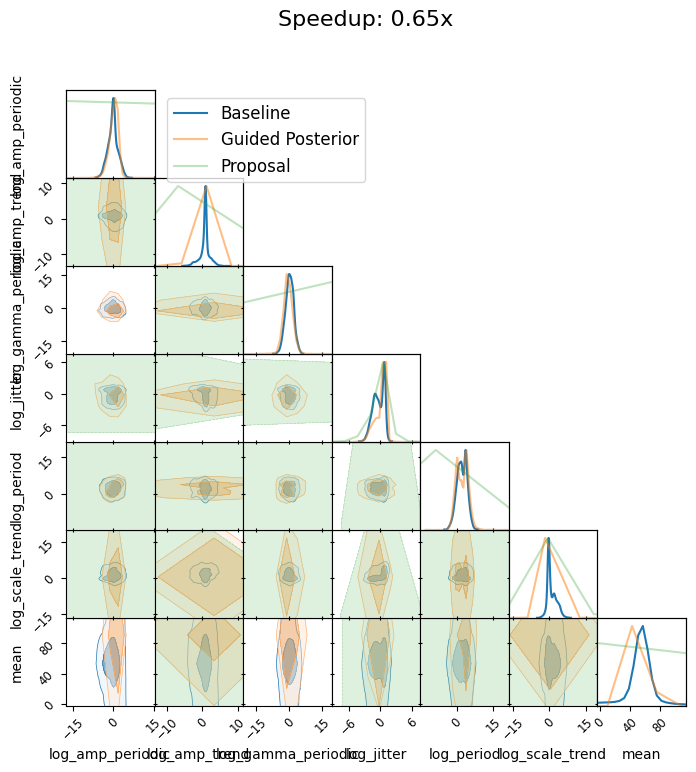

In [55]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from anesthetic import NestedSamples, make_2d_axes, MCMCSamples
import jax
import jax.numpy as jnp

# --- 1. CONVERSION HELPER ---
def to_anesthetic(dead_list, state, names, nlive):
    # Stack BlackJAX history (list of pytrees) into arrays
    stack = jax.tree_util.tree_map(lambda *args: jnp.stack(args), *dead_list)

    d_params = np.array(stack.particles)
    l_params = np.array(state.particles)

    # FIX 1: Flatten the batch dimension if it exists (Steps, Batch, Dim) -> (Total, Dim)
    if d_params.ndim == 3:
        d_params = d_params.reshape(-1, d_params.shape[-1])

    # Extract logL (Robust handle for 'loglikelihood' vs 'log_likelihood')
    d_logL = np.array(getattr(stack, 'log_likelihood', getattr(stack, 'loglikelihood', None)))
    l_logL = np.array(getattr(state, 'log_likelihood', getattr(state, 'loglikelihood', None)))

    # FIX 2: Flatten logL batch dimension if it exists (Steps, Batch) -> (Total,)
    if d_logL.ndim == 2:
        d_logL = d_logL.flatten()

    # Combine
    data = pd.DataFrame(np.concatenate([d_params, l_params]), columns=names)
    data['logL'] = np.concatenate([d_logL, l_logL])

    # Tiny jitter to prevent triangulation crashes on identical points
    for col in names:
        data[col] += np.random.normal(0, data[col].std() * 1e-5, size=len(data))

    # FIX 3: Do not pass nlive to __init__, set it as an attribute
    samples = NestedSamples(data=data, logL=data['logL'])
    samples.nlive = nlive
    return samples

# --- 2. PREPARE SAMPLES ---
param_names = list(unravel_fn(flat_init).keys())

# A. Baseline
print("Processing Baseline...")
s_base = to_anesthetic(dead_baseline, state, param_names, n_live)

# B. Repartitioned
print("Processing Repartitioned...")
s_repart = to_anesthetic(dead_repart, state_2, param_names, n_live)

# C. Proposal (Student-t)
print("Generating Proposal samples...")
rng_key, k_vis = jax.random.split(rng_key)
prop_draws = np.array(sample_fresh(k_vis, 5000))
s_prop = MCMCSamples(data=pd.DataFrame(prop_draws, columns=param_names))

# --- 3. PLOTTING ---
print("Plotting...")
fig, axes = make_2d_axes(param_names, upper=False, figsize=(8, 8))

# Layer 1: Baseline (Blue)
s_base.plot_2d(axes, label="Baseline", color='C0')

# Layer 2: Guided Posterior (Orange)
s_repart.plot_2d(axes, label="Guided Posterior", color='C1', alpha=0.5)

# Layer 3: Proposal (Green Dashed)
s_prop.plot_2d(axes, label="Proposal", color='C2', alpha=0.3,
               lower_kwargs={'linestyles': '--', 'levels': [0.95]})

# --- 4. SMART ZOOM ---
# Focus axes on the Guided Posterior results
buffer = 1
for y in param_names:
    for x in param_names:
        if x in axes and y in axes[x]:
            ax = axes.loc[y, x]
            if ax is None: continue

            # Get limits from Repartitioned run (ignoring top/bottom 0.5% outliers)
            xd = s_repart[x]
            xmin, xmax = xd.quantile(0.005), xd.quantile(0.995)
            ax.set_xlim(xmin - (xmax-xmin)*buffer, xmax + (xmax-xmin)*buffer)

            if x != y:
                yd = s_repart[y]
                ymin, ymax = yd.quantile(0.005), yd.quantile(0.995)
                ax.set_ylim(ymin - (ymax-ymin)*buffer, ymax + (ymax-ymin)*buffer)

plt.suptitle(f"Speedup: {t_base / (t_repart + t_optim):.2f}x", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.show()

In [ ]:
fig.savefig("Bad_run.pdf")


--- GENERATING PLOTS ---
Computing GP predictions for visualization...


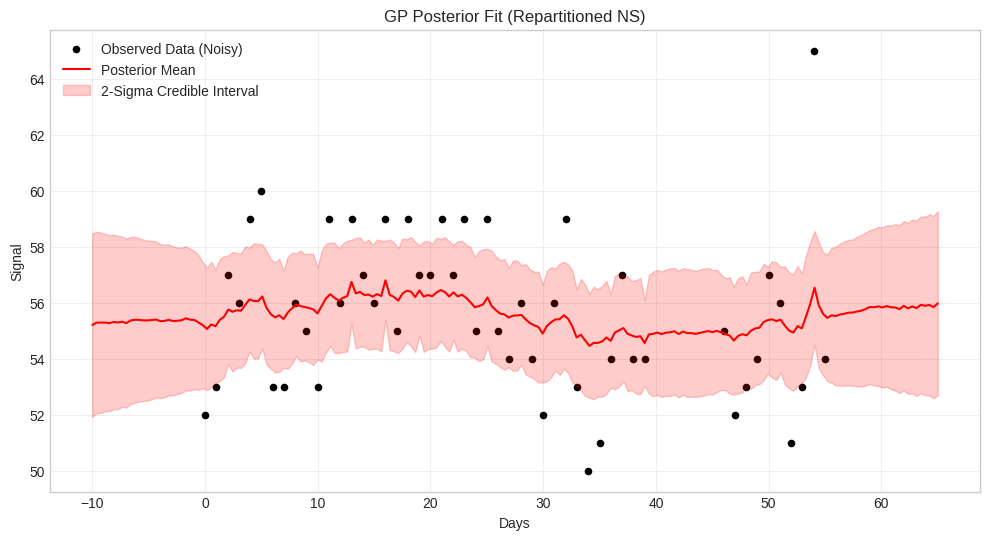

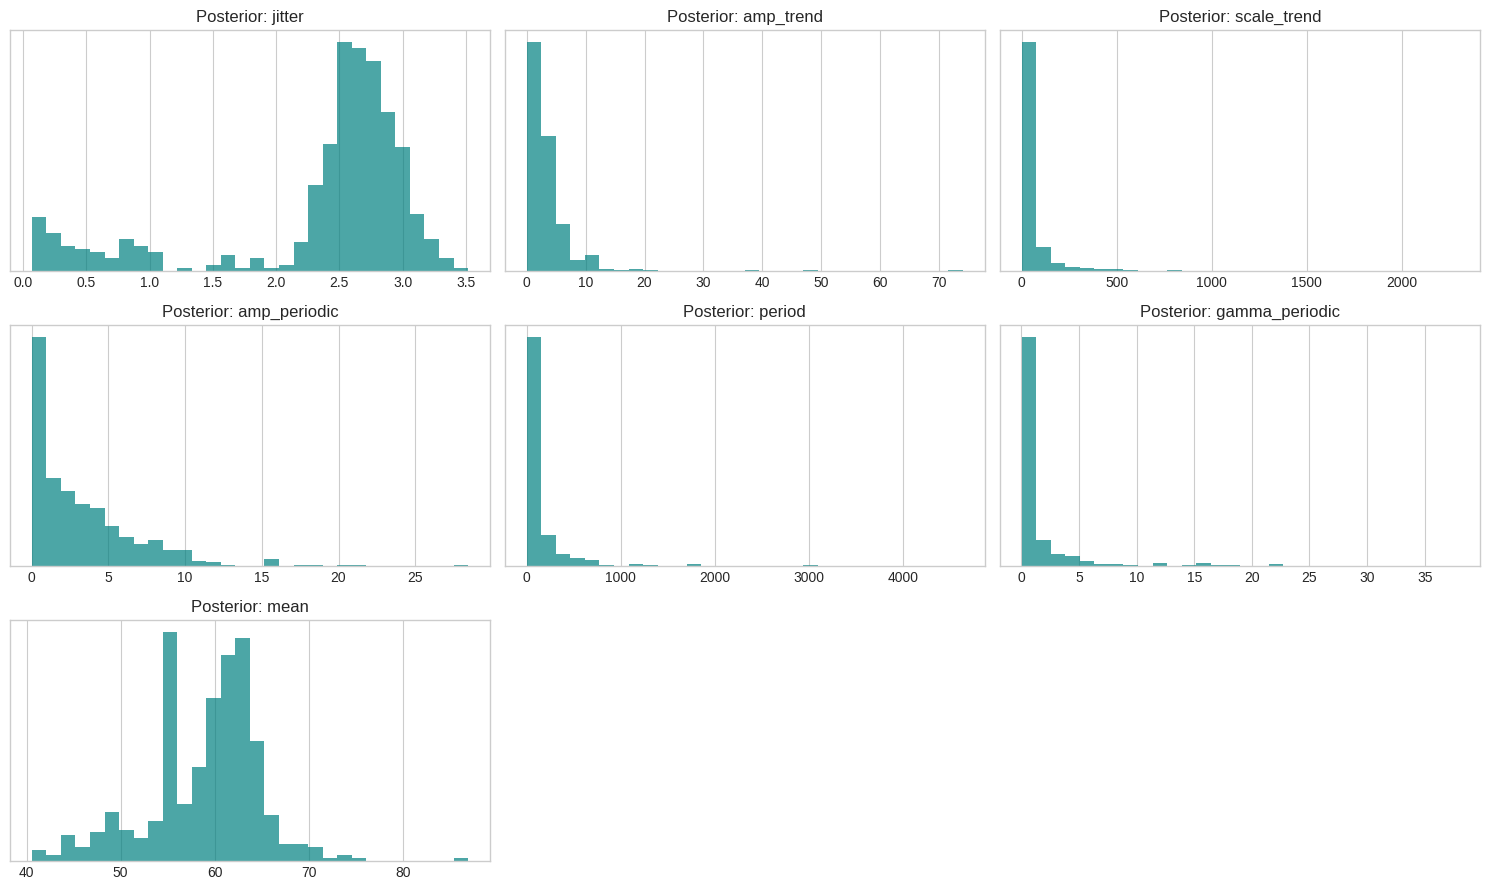

In [ ]:
# ==========================================
# 6. VISUALIZATION
# ==========================================
print("\n--- GENERATING PLOTS ---")

# 1. EXTRACT SAMPLES (Final Live Points)
# In a full run, you would combine dead_points + live_points weighted by volume.
# For a quick visual, the final live points are excellent samples of the core posterior.
flat_samples = state_2.particles
# flat_samples shape: (n_live, D)

# 2. HELPER: PREDICTION FUNCTION
# We need to turn flat parameters back into GP predictions
X_test = jnp.linspace(X.min() - 10, X.max() + 10, 200)

@jit
def get_gp_prediction(theta_flat):
    params = unravel_fn(theta_flat)

    # Reconstruct the GP with these specific parameters
    gp = build_gp(params, X)

    # Condition on the observed data (y)
    # strict=False allows computing covariance even if matrix is slightly ill-conditioned
    cond = gp.condition(y, X_test).gp

    return cond.loc, cond.variance

# 3. COMPUTE PREDICTIONS (Parallelized)
print("Computing GP predictions for visualization...")
# We pick a random subset of 100 samples to avoid cluttering the plot or running OOM
rng_key, plot_key = random.split(rng_key)
subset_indices = random.choice(plot_key, flat_samples.shape[0], shape=(100,), replace=False)
subset_samples = flat_samples[subset_indices]

# vmap over the samples to get 100 predictions at once
means, variances = vmap(get_gp_prediction)(subset_samples)
stds = jnp.sqrt(variances)

# 4. PLOT 1: GP FIT vs DATA
plt.figure(figsize=(12, 6))

# Plot Data
plt.scatter(X, y, c='k', s=20, label="Observed Data (Noisy)")

# Plot Model Uncertainty (The "Bands")
# We average the predictions of our samples
mean_pred = jnp.mean(means, axis=0)
std_pred = jnp.mean(stds, axis=0) # Approx avg sigma

plt.plot(X_test, mean_pred, 'r-', label="Posterior Mean")
plt.fill_between(X_test, mean_pred - 2*std_pred, mean_pred + 2*std_pred,
                 color='r', alpha=0.2, label="2-Sigma Credible Interval")

plt.xlabel("Days")
plt.ylabel("Signal")
plt.title("GP Posterior Fit (Repartitioned NS)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 5. PLOT 2: PARAMETER DISTRIBUTIONS
# We want to see if we recovered the period (~7.0) and other parameters.
# We transform back from log-space to physical space for readability.

params_pytree = vmap(unravel_fn)(flat_samples)

# Setup a grid of histograms
param_names = list(prior_params.keys())
n_params = len(param_names)
cols = 3
rows = (n_params + cols - 1) // cols

plt.figure(figsize=(15, 3 * rows))

for i, key in enumerate(param_names):
    plt.subplot(rows, cols, i+1)

    # Get values
    vals = params_pytree[key]

    # Transform back if it was logged in the prior definition
    # (Based on your prior_params structure)
    if "log_" in key:
        vals = jnp.exp(vals)
        title_key = key.replace("log_", "")
    else:
        title_key = key

    plt.hist(np.array(vals), bins=30, density=True, color='teal', alpha=0.7)

    # Add vertical line for "Truth" if known (approximate for this synthetic data)

    plt.title(f"Posterior: {title_key}")
    plt.yticks([])

plt.tight_layout()
plt.show()

In [ ]:
plt.savefig("repart_run_posteriors.png")

<Figure size 640x480 with 0 Axes>

In [ ]:
# --- 5. Visualize the Results ---
# This section remains unchanged, but we now use `posterior_samples` directly.
num_plot_samples = 100
rng_key, predict_key = jax.random.split(rng_key)
choice = jax.random.choice(predict_key, len(posterior_samples['knot_x']), shape=(num_plot_samples,))
plot_samples = {k: v[choice] for k, v in posterior_samples.items()}

X_plot = jnp.linspace(X.min(), X.max(), 500)

@jax.vmap
def predict(params):
    gp = build_gp(params, X)
    cond_gp = gp.condition(y, X_plot).gp
    # We need a new random key for each sample
    return cond_gp.sample(jax.random.PRNGKey(jnp.sum(params['knot_x']).astype(int)))

predictions = predict(plot_samples)


In [ ]:
import time
import jax
import jax.numpy as jnp
from jax.scipy.stats import norm
from jax import jit, vmap, random, value_and_grad, lax
from jax.scipy.special import logsumexp
from jax.flatten_util import ravel_pytree
import tinygp
import blackjax
from functools import partial
import tqdm
import matplotlib.pyplot as plt
import optax
import numpy as np

# Enable 64-bit precision
jax.config.update("jax_enable_x64", True)

# ==========================================
# 1. SETUP: DATA & MODEL
# ==========================================

rng_key = jax.random.PRNGKey(42)

start_date = dates[0]
X = jnp.array([(date - start_date).days for date in dates])
y = jnp.array(resting_hr)
print(len(X))


y0, y1, x1 = y[0], y[-1], X[-1]


print(f"Data points: {len(X)}")

# --- GP Model Definition ---
def build_gp(params, X):
    kernel_trend = jnp.exp(2 * params["log_amp_trend"]) * tinygp.kernels.Matern32(jnp.exp(params["log_scale_trend"]))
    kernel_periodic = jnp.exp(2 * params["log_amp_periodic"]) * tinygp.kernels.ExpSineSquared(
        scale=jnp.exp(params["log_period"]), gamma=jnp.exp(params["log_gamma_periodic"]))
    kernel = kernel_trend + kernel_periodic

    return tinygp.GaussianProcess(kernel, X, diag=jnp.exp(2 * params["log_jitter"]), mean=params['mean'])

prior_params = {
    "log_jitter": (-1.0, 1.0),
    "log_amp_trend": (0.0, 2.0),
    "log_scale_trend": (2.0, 2.0),
    "log_amp_periodic": (0.0, 2.0),
    "log_period": (2.0, 2.0), # centered on ~7.3 days
    "log_gamma_periodic": (0.0, 2.0),
    "mean": (50.0, 20.0) # Adjusted slightly for synthetic data
}

init_dummy = {k: v[0] for k, v in prior_params.items()}
flat_init, unravel_fn = ravel_pytree(init_dummy)
D = len(flat_init)

# ==========================================
# 2. BASE LOG PROBS
# ==========================================
t0 = time.time()

@jit
def log_likelihood_flat(theta_flat):
    params = unravel_fn(theta_flat)
    gp = build_gp(params, X)
    return gp.log_probability(y)

@jit
def log_prior_flat(theta_flat):
    params = unravel_fn(theta_flat)
    logp = 0.0
    for k, (loc, scale) in prior_params.items():
        logp += norm.logpdf(params[k], loc=loc, scale=scale)
    return logp

@jit
def log_posterior_total(theta):
    return log_likelihood_flat(theta) + log_prior_flat(theta)

# ==========================================
# 3. RUN 1: BASELINE (For Comparison)
# ==========================================
print("--- STARTING RUN 1: BASELINE ---")
# NOTE: This run is completely independent of the optimization run below.

n_live = 500
num_delete = n_live // 2
ns_algo = blackjax.nss(
    logprior_fn=log_prior_flat, loglikelihood_fn=log_likelihood_flat,
    num_delete=num_delete, num_inner_steps=D * 2
)

# Init Particles from Prior
rng_key, init_key = jax.random.split(rng_key)
init_particles_list = []
for _ in range(n_live):
    rng_key, subk = random.split(rng_key)
    p_samp = {k: loc + scale * random.normal(random.fold_in(subk, i))
              for i, (k, (loc, scale)) in enumerate(prior_params.items())}
    init_particles_list.append(ravel_pytree(p_samp)[0])
initial_particles_baseline = jnp.stack(init_particles_list)

state = ns_algo.init(initial_particles_baseline, log_likelihood_flat)
step_fn = jit(ns_algo.step)

# Run Loop
with tqdm.tqdm(desc="Baseline Run", unit=" dead") as pbar:
    while (state.logZ_live - state.logZ) > -3:
        rng_key, step_key = random.split(rng_key)
        state, info = step_fn(step_key, state)
        pbar.update(len(info.particles))

t_base = time.time() - t0
logZ_base = state.logZ
print(f"Baseline LogZ: {logZ_base:.2f} | Time: {t_base:.2f}s")


# ==========================================
# 4. PREPARATION FOR RUN 2: OPTIMIZATION
# ==========================================
print("\n--- PREPARING REPARTITIONED RUN (OPTIMIZATION) ---")
# We do NOT use results from Run 1. We start fresh from the Prior.

t_opt_start = time.time()

# 4a. Find Modes using Optimization
def find_modes_parallel(rng, n_candidates=100):
    # Sample random start points from the Prior
    starts = []
    for _ in range(n_candidates):
        rng, subk = random.split(rng)
        p_samp = {k: loc + scale * random.normal(random.fold_in(subk, i))
                  for i, (k, (loc, scale)) in enumerate(prior_params.items())}
        starts.append(ravel_pytree(p_samp)[0])
    starts = jnp.stack(starts)

    optimizer = optax.adam(0.1)

    def optimize_single(start_pt):
        state = optimizer.init(start_pt)
        def step(c, _):
            p, s = c
            # Maximize Log Posterior
            grads = jax.grad(lambda x: -log_posterior_total(x))(p)
            updates, s = optimizer.update(grads, s)
            return (optax.apply_updates(p, updates), s), None
        (final_pt, _), _ = lax.scan(step, (start_pt, state), None, length=200)
        return final_pt

    candidates = vmap(optimize_single)(starts)

    # Filter for unique modes
    cands_np = np.array(candidates)
    scores = vmap(log_posterior_total)(candidates)

    # Sort by score
    sorted_idx = np.argsort(np.array(scores))[::-1]
    cands_np = cands_np[sorted_idx]

    # Simple Euclidean distance filter
    unique_modes = []
    for c in cands_np:
        if len(unique_modes) == 0: unique_modes.append(c)
        else:
            dists = np.linalg.norm(np.array(unique_modes) - c, axis=1)
            # Threshold: if further than 1.0 unit in parameter space
            if np.all(dists > 1.0): unique_modes.append(c)

    return jnp.array(unique_modes)

# 4b. Gaussian Mixture Helpers
def construct_gaussian_mixture(modes, hessians, inflation_factor=10.0):
    """
    Constructs Gaussian parameters directly from Optimization results.
    INFLATION is critical: We widen the covariance to ensure we cover the tails.
    """
    k = len(modes)

    def clean_precision(H):
        # 1. Eigen decomposition
        vals, vecs = jnp.linalg.eigh(-H) # H is usually neg-def at peak

        # 2. Clip small eigenvalues (flat directions)
        vals = jnp.maximum(vals, 1e-6)

        # 3. INFLATE: Divide curvature by factor -> Multiplies Variance
        vals = vals / inflation_factor

        # Reconstruct Precision Matrix
        return vecs @ jnp.diag(vals) @ vecs.T

    Ps = vmap(clean_precision)(hessians)

    # Uniform weights (since we don't know volume yet)
    weights = jnp.ones(k) / k

    return modes, Ps, weights

@jit
def log_prior_gaussian_mixture(theta, modes, Ps, weights):
    def gaussian_logpdf(mu, P, w):
        diff = theta - mu
        delta = jnp.sum((diff @ P) * diff)
        _, log_det = jnp.linalg.slogdet(P)
        # Log Normal PDF + Log Weight
        return -0.5 * (D * jnp.log(2 * jnp.pi) - log_det + delta) + jnp.log(w)

    return logsumexp(vmap(gaussian_logpdf)(modes, Ps, weights))

@partial(jit, static_argnums=(1,))
def sample_gaussian_mixture(key, n, modes, Ps, weights):
    k1, k2, k3 = random.split(key, 3)

    # 1. Select Component
    choices = random.choice(k1, len(weights), shape=(n,), p=weights)
    sel_mus = modes[choices]
    sel_Ps = Ps[choices]

    # 2. Sample Standard Normal
    z = random.normal(k2, shape=(n, D))

    # 3. Transform: x = mu + Chol(Cov) @ z
    # Cov = inv(P). We need L such that L L^T = Cov.
    covs = jnp.linalg.inv(sel_Ps)
    Ls = jnp.linalg.cholesky(covs)

    def trans(L, z_i): return L @ z_i
    return sel_mus + vmap(trans)(Ls, z)


# --- EXECUTE OPTIMIZATION ---

rng_key, k_fit = random.split(rng_key)
# 1. Find Modes
modes_fit = find_modes_parallel(k_fit, n_candidates=100)
print(f"   Found {len(modes_fit)} unique modes.")

# 2. Calculate Curvature (Hessian) at modes
hessians = vmap(jax.hessian(log_posterior_total))(modes_fit)

# 3. Construct Proposal (With Inflation)
# Factor 10.0 implies Standard Deviation is sqrt(10) ~ 3.16x wider than the Laplace approx.
Ps_fit, weights_fit = None, None
modes_fit, Ps_fit, weights_fit = construct_gaussian_mixture(modes_fit, hessians, inflation_factor=10.0)

t_optim = time.time() - t_opt_start
print(f"Optimization Time: {t_optim:.2f}s")


# ==========================================
# 5. RUN 2: REPARTITIONED (Gaussian Proposal)
# ==========================================
print("\n--- STARTING RUN 2: REPARTITIONED ---")

# 1. Sample new live points from the Gaussian Mixture
rng_key, subk = random.split(rng_key)
initial_particles_2 = sample_gaussian_mixture(subk, n_live, modes_fit, Ps_fit, weights_fit)
_ = initial_particles_2.block_until_ready() # Force computation

# 2. Define Repartitioned Likelihood
# L_new = L_old * (Prior_Old / Prior_New)
# log(L_new) = log(L_old) + log(Prior_Old) - log(Prior_New)

@jit
def log_prior_new(theta):
    return log_prior_gaussian_mixture(theta, modes_fit, Ps_fit, weights_fit)

@jit
def log_likelihood_repart(theta):
    ll = log_likelihood_flat(theta)
    lp_old = log_prior_flat(theta)
    lp_new = log_prior_new(theta)
    return ll + lp_old - lp_new

# 3. Setup Nested Sampling
# Note: We pass log_prior_new as the prior function to sample from!
ns_algo_repart = blackjax.nss(
    logprior_fn=log_prior_new,
    loglikelihood_fn=log_likelihood_repart,
    num_delete=num_delete, num_inner_steps=D # Often need fewer steps due to better geometry
)

state_2 = ns_algo_repart.init(initial_particles_2, log_likelihood_repart)
step_fn_2 = jit(ns_algo_repart.step)

t0_repart = time.time()

# 4. Run Loop
with tqdm.tqdm(desc="Repartitioned Run", unit=" dead") as pbar:
    while (state_2.logZ_live - state_2.logZ) > -3:
        rng_key, step_key = random.split(rng_key)
        state_2, info = step_fn_2(step_key, state_2)
        pbar.update(len(info.particles))

t_repart = time.time() - t0_repart
logZ_repart = state_2.logZ

print("\n=== RESULTS ===")
print(f"Baseline LogZ:      {logZ_base:.2f}")
print(f"Repartitioned LogZ: {logZ_repart:.2f}")
print(f"Baseline Time:      {t_base:.2f}s")
print(f"Optimization Time:  {t_optim:.2f}s")
print(f"Repartitioned Time: {t_repart:.2f}s")
print(f"Total Repart Time:  {t_optim + t_repart:.2f}s")
print(f"Speedup Factor:     {t_base / (t_optim + t_repart):.2f}x")

In [ ]:
import jax
import jax.numpy as jnp
from jax.scipy.stats import norm
import tinygp
import blackjax
from blackjax.ns.utils import finalise # Utility for processing results
import matplotlib.pyplot as plt
from functools import partial
import tqdm # For a nice progress bar

# Enable 64-bit precision for more stable computations
jax.config.update("jax_enable_x64", True)


rng_key = jax.random.PRNGKey(42)
rng_key, data_key = jax.random.split(rng_key)
start_date = dates[0]
X = jnp.array([(date - start_date).days for date in dates])
y = jnp.array(resting_hr)
y0 = y[0]
y1 = y[-1]
x1 = X[-1]
def flexknot(params, X):
  seg1 = X*jnp.where(X<=params['knot_x'],(params['knot_y']-y0)/params['knot_x'],0)+jnp.where(X<=params['knot_x'],0,(params['knot_y']-y0))
  seg2=(X-params['knot_x'])*jnp.where(X<=params['knot_x2'],(params['knot_y2']-params['knot_y'])/(params['knot_x2']-params['knot_x']),0)+jnp.where(X<=params['knot_x2'],0,(params['knot_y2']-params['knot_y']))
  seg3 = (X-params['knot_x2'])*jnp.where(X<=params['knot_x3'],(params['knot_y3']-params['knot_y2'])/(params['knot_x3']-params['knot_x2']),0)+jnp.where(X<=params['knot_x3'],0,(params['knot_y3']-params['knot_y2']))
  seg4 = (X-params['knot_x3'])*jnp.where(X<=params['knot_x3'],0,(y1-params['knot_y3'])/(x1-params['knot_x3']))

  return y0+seg1+seg2+seg3+seg4




# --- 2. Define the GP Model with tinygp ---
# This section remains unchanged
def build_gp(params, X):
    kernel_trend = jnp.exp(2 * params["log_amp_trend"]) * tinygp.kernels.Matern32(
        jnp.exp(params["log_scale_trend"])
    )
    kernel_periodic = jnp.exp(2 * params["log_amp_periodic"]) * tinygp.kernels.ExpSineSquared(
        scale=jnp.exp(params["log_period"]),
        gamma=jnp.exp(params["log_gamma_periodic"])
    )
    kernel = kernel_trend + kernel_periodic


    return tinygp.GaussianProcess(
        kernel, X, diag=jnp.exp(2 * params["log_jitter"]), mean=partial(flexknot,params)
    )

# --- 3. Define Priors and Likelihood using only JAX ---
# This section remains unchanged
prior_params = {
    "log_jitter": (-1.0, 1.0),
    "log_amp_trend": (0.0, 2.0),
    "log_scale_trend": (2.0, 2.0),
    "log_amp_periodic": (0.0, 2.0),
    "log_period": (2.0, 2.0),
    "log_gamma_periodic": (0.0, 2.0),
    "knot_x": (150.0, 100.0),
    "knot_y": (60.0, 50.0),
    "knot_x2": (250.0, 100.0),
    "knot_y2": (60.0, 50.0),
    "knot_x3": (450.0, 100.0),
    "knot_y3": (60.0, 50.0),

}

paranames = list(prior_params.keys())


def log_prior_fn(params_dict):
    return jnp.sum(
        jnp.array([
            norm.logpdf(params_dict[k], loc=loc, scale=scale)
            for k, (loc, scale) in prior_params.items()
        ])
    )

def log_likelihood_fn(params_dict, X, y):
    gp = build_gp(params_dict, X)
    return gp.log_probability(y)

# --- 4. Run Nested Sampling with the Correct blackjax API ---
# This is the section that has been updated.





In [ ]:
num_live_points = 500
log_likelihood = partial(log_likelihood_fn, X=X, y=y)

# Initialize the nested sampling algorithm object
# `blackjax.nss` is the new top-level API for this sampler.
ns_algorithm = blackjax.nss(
    logprior_fn=log_prior_fn,
    loglikelihood_fn=log_likelihood,
    num_delete = 60,
    num_inner_steps=2  # Steps to take to find a new point
)

# Manually draw initial samples from the prior distributions as a dictionary
rng_key, init_key = jax.random.split(rng_key)
keys = jax.random.split(init_key, len(prior_params))
initial_params_dict = {}
for i, (k, (loc, scale)) in enumerate(prior_params.items()):
    initial_params_dict[k] = loc + scale * jax.random.normal(keys[i], (num_live_points,))

# Initialize the sampler state
rng_key, init_alg_key = jax.random.split(rng_key)
initial_state = ns_algorithm.init(initial_params_dict, init_alg_key)

# Define the step function and jit-compile it for speed
@jax.jit
def step(rng_key, state):
    return ns_algorithm.step(rng_key, state)

# Run the nested sampling loop
dead_points = []
pbar = tqdm.tqdm(desc="Nested Sampling", unit=" dead points")
while (initial_state.logZ_live - initial_state.logZ) > -3: # A common stopping condition
    rng_key, step_key = jax.random.split(rng_key)
    initial_state, dead = step(step_key, initial_state)
    dead_points.append(dead)
    pbar.update(len(dead.particles['log_jitter'])) # Update progress bar
pbar.close()

# Combine the final live points with the dead points to get the full run
ns_run = finalise(initial_state, dead_points)
posterior_samples = ns_run.particles


In [ ]:
log_evidence = initial_state.logZ_live
print(f"Log Evidence: {log_evidence}")

In [ ]:
plt.figure(figsize=(12, 6))
# plt.plot(X_plot, predictions.T, color="C0", alpha=0.1)
plt.plot(X, y, "ok", label="Data")
plt.plot(X,flexknot(mean_params,X))
mu = jnp.mean(predictions, axis=0)
percentiles = jnp.percentile(predictions, jnp.array([2.5, 97.5]), axis=0)
plt.plot(X_plot, mu, color="C1", label="Posterior Mean")
plt.fill_between(X_plot, percentiles[0], percentiles[1], color='C1', alpha=0.3, label="95% CI")
plt.xlabel("Days")
plt.ylabel("Resting Heart Rate")
plt.title("Gaussian Process Fit with tinygp and blackjax.nss")
plt.legend()
plt.show()